# RL example:

In this example, we tune a model predictive control (MPC) controller that recursively solves the optimal control problem (OCP): 
\begin{align*}
\textbf{OCP}:\quad
\mathop{\textrm{argmin}}_{(x,u)}  
\ \ 
(x_t-x^{\text{ref}})^\top Q_T^\theta (x_t-x^{\text{ref}})
+
\sum_{t=0}^{T-1} 
(x_t-x^{\text{ref}})^\top Q^\theta (x_t-x^{\text{ref}})
+ 
\sum_{t=0}^{T-1} 
(u_t-u^{\text{ref}})^\top R^\theta (u_t-u^{\text{ref}})
\ \ \text{ s.t. }  \ \ 
x_{t+1}=f(x_t,u_t), 
\quad
x_0 = x_s, 
\end{align*}
where $\theta$ are trainable parameters that parameterize the quadratic costs:
$$
Q_T^\theta=\text{diag}(\theta_{1:13}),
\quad
Q^\theta=\text{diag}(\theta_{14:26}),
\quad
R^\theta=\text{diag}(\theta_{27:30}),
$$
The weights $\theta$ are trained via gradient descent on the RL problem:
$$
\max_\theta
\ 
\mathbb{E}\left[
\sum_{t=1}^H R(x_t, \pi^\theta(x_t))
\right],
\ \ 
x_{t+1}=\textrm{SimEnv}(x_t,\pi^\theta(x_t)),
\ \ 
x_0\sim\mathcal{D}_{\text{initial states}},
$$
where $\pi^\theta(x_t)$ is the first control of the MPC solution to OCP with initial state $x_t$, and $R$ is the reward function
$$
R(x,u)=-(\|x_{1:3}\|^2+0.1\|u\|^2).
$$

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import time

import matplotlib.pyplot as plt
from jax import config

config.update("jax_enable_x64", True)  # use double precision

import jax
import jax.numpy as jnp
from jax import jit, vmap

from diffmpc.dynamics.integrators import DiscretizationScheme, predict_next_state
from diffmpc.dynamics.quadrotor_dynamics import QuadrotorDynamics
from diffmpc.problems.optimal_control_problem import OptimalControlProblem
from diffmpc.solvers.sqp import SQPSolver
from diffmpc.utils.load_params import (
    load_problem_params,
    load_solver_params,
)

### RL: Define domain randomization & reward

In [3]:
"""Utilities"""
import numpy as np

def reward(state, control, reference_state, reference_control):
    delta_state = state - reference_state
    delta_control = control - reference_control
    # r = - (jnp.sum(delta_state[:3]**2) + 1e-9 * jnp.sum(delta_state[3:]**2) + 1e-3 * jnp.sum(control**2))
    r = - (jnp.sum(delta_state[:3]**2) + 1e-1 * jnp.sum(delta_control**2))
    # r = - (100 * jnp.sum(delta_state[:3]**2) + 1e-3 * jnp.sum(delta_control**2))
    return r

def generate_problem_data(batch_size, seed):
    """Generate quadrotor problem data for benchmarking"""
    np.random.seed(seed)

    initial_states = np.array([0., 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    initial_states = np.repeat(initial_states[None], repeats=batch_size, axis=0)

    min_pos = -4.
    max_pos = 4.
    initial_positions = min_pos + np.random.rand(batch_size, 3) * (max_pos - min_pos)
    initial_states[:, :3] = initial_positions

    min_vel = -0.1
    max_vel = 0.1
    initial_velocities = min_vel + np.random.rand(batch_size, 3) * (max_vel - min_vel)
    initial_states[:, 3:6] = initial_velocities

    min_vel = -0.1
    max_vel = 0.1
    delta = 0.5 * np.random.randn(4,)
    initial_quaternion = np.array([1,0,0,0]) + delta / np.linalg.norm(delta)
    initial_states[:, 6:10] = initial_quaternion / np.linalg.norm(initial_quaternion)

    initial_states = jnp.array(initial_states)

    mass    = 0.1 * jnp.ones(1)
    inertia = jnp.array([0.1, 0.01, 0.01, 0.01, 0.1, 0.01, 0.01, 0.01, 0.1])

    return mass, inertia, initial_states

### Define problem and solver parameters

In [5]:
horizon = 20
num_sim_steps = 10
num_steps = 20
lr = 1e-4  # learning rate
batch_size = 1

# Problem parameters
mass, inertia, initial_states = generate_problem_data(batch_size, seed=0)
print(f"device: {inertia.device}")

problem_params = load_problem_params("quadrotor.yaml")
diffmpc_horizon = horizon - 1  # diffmpc horizon is N+1
problem_params["horizon"] = diffmpc_horizon
problem_params["mass"] = mass
problem_params["inertia"] = inertia
problem_params["initial_state"] = initial_states[0]
reference_state = problem_params["reference_state_trajectory"][0]
reference_control = problem_params["reference_control_trajectory"][0]
problem_params["reference_state_trajectory"] = jnp.repeat(
    problem_params["reference_state_trajectory"][0:1], diffmpc_horizon + 1, axis=0
)
problem_params["reference_control_trajectory"] = jnp.repeat(
    problem_params["reference_control_trajectory"][0:1], diffmpc_horizon + 1, axis=0
)

# Solver parameters
solver_params = load_solver_params("sqp.yaml")
solver_params["num_scp_iteration_max"] = 50
solver_params["pcg"]["tol_epsilon"] = 1.0e-12
solver_params["linesearch"] = True

device: TFRT_CPU_0


In [6]:
dynamics = QuadrotorDynamics()
problem = OptimalControlProblem(dynamics=dynamics, params=problem_params)
solver = SQPSolver(program=problem, params=solver_params)

def solver_initial_guess(initial_state):
    params = {**problem_params, "initial_state": initial_state}
    # straight line
    guess = solver.initial_guess(params)
    # normalize quaternion
    quaternions = guess.states[:, 6:10]
    def normalize(q):
        return q / jnp.linalg.norm(q)
    quaternions = vmap(normalize)(quaternions)
    # 
    controls = jnp.repeat(jnp.array([[1., 0., 0., 0.]]), repeats=horizon, axis=0)
    guess = guess._replace(
        states = guess.states.at[:, 6:10].set(quaternions),
        controls = controls
    )
    return guess
        
# trainable parameters
weights = {
    k: problem_params[k]
    for k in [
        "weights_penalization_reference_state_trajectory",
        "weights_penalization_control_squared",
        "weights_penalization_final_state",
    ]
}
problem_params["initial_state"] = initial_states[0]

#### Solution with nominal MPC parameters before RL 

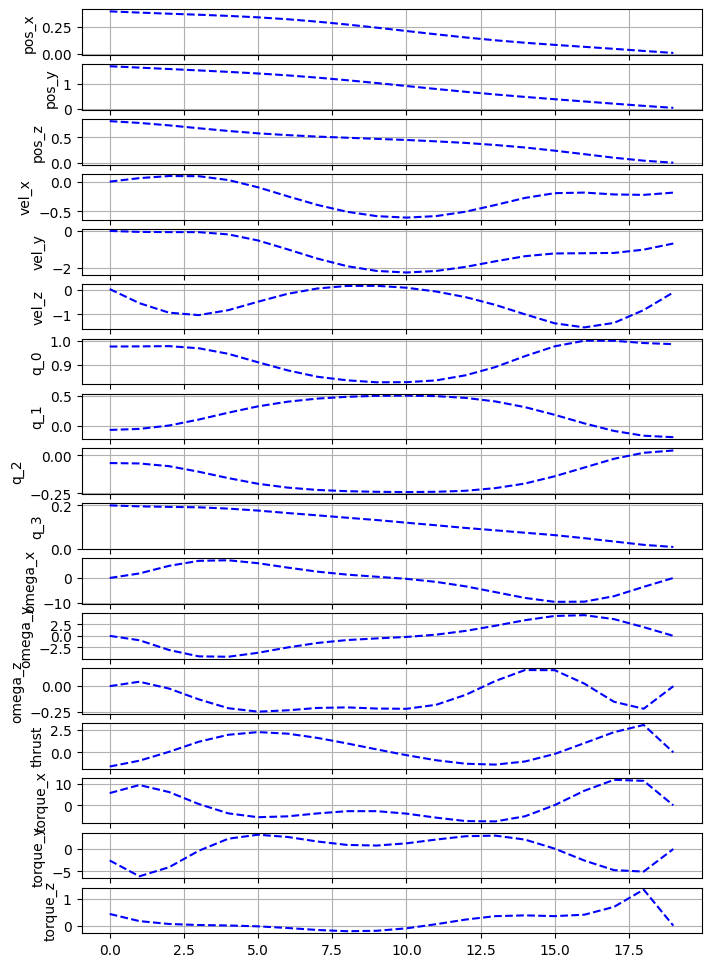

In [7]:
### Solve the problem with nominal MPC parameters (pre-RL)
solution_baseline = solver.solve(
    solver.initial_guess(problem_params), problem_params, weights
)

# plot rollouts with base weights (pre-RL)
fig, axes = plt.subplots(
    nrows=dynamics.num_states + dynamics.num_controls, figsize=(8, 12)
)
for i, ax in enumerate(axes.flatten()):
    if i < dynamics.num_states:
        ax.plot(solution_baseline.states[:, i], "b--", label="Pre-RL")
        ax.set_ylabel(dynamics.names_states[i])
    else:
        ax.plot(solution_baseline.controls[:, i-dynamics.num_states], "b--", label="Pre-RL")
        ax.set_ylabel(dynamics.names_controls[i-dynamics.num_states])
    ax.grid(True)

### RL training functions

In [8]:
def rollout(state, weights):
    initial_carry = (state, solver_initial_guess(state), 0.0)

    def rollout_step(carry, _):
        state, solution, running_reward = carry

        # Solve MPC problem
        params = {
            **problem_params,
            "mass": mass,
            "inertia": inertia,
            "initial_state": state
        }
        solution = solver.solve(solution, params, weights)
        control = solution.controls[0]

        # Simulate forward
        dt = params["discretization_resolution"]
        next_state = predict_next_state(
            dynamics,
            dt,
            DiscretizationScheme.RUNGEKUTTA4,
            params,
            state,
            control,
        )
        running_reward = running_reward + reward(next_state, control, reference_state, reference_control)

        return (next_state, solution, running_reward), None

    final_carry, _ = jax.lax.scan(
        rollout_step, initial_carry, None, length=num_sim_steps
    )
    _, _, final_reward = final_carry
    return final_reward

rollout_batch = vmap(rollout, in_axes=(0, None))

def rollout_for_grad(weights):
    return jnp.sum(rollout_batch(initial_states, weights))

@jit
def grad_step_and_loss(weights):
    loss, grad = jax.value_and_grad(rollout_for_grad)(weights)
    for key in weights.keys():
        weights[key] = jnp.maximum(
            1e-5, weights[key] + lr * jnp.nan_to_num(grad[key])
        )
    return weights, loss

jax.block_until_ready(grad_step_and_loss(weights))

({'weights_penalization_control_squared': Array([9.99942068, 0.15323796, 0.1305838 , 0.0997631 ], dtype=float64),
  'weights_penalization_final_state': Array([100000.        , 100000.        , 100000.        ,    999.99999999,
            999.99999999,   1000.00000003,    999.99999991,    999.99999886,
            999.99999981,   1000.        ,   1000.        ,   1000.        ,
           1000.        ], dtype=float64),
  'weights_penalization_reference_state_trajectory': Array([9.50212555e-05, 5.50212272e-05, 1.53135675e-04, 9.99869812e-02,
         9.94175966e-02, 9.98137836e-02, 8.77389757e-05, 5.59936724e-05,
         9.31597033e-05, 8.72639105e-05, 9.41310499e-02, 9.55853424e-02,
         9.96161509e-02], dtype=float64)},
 Array(-241.93737859, dtype=float64))

### RL training loop

In [9]:
jax.debug.print("Pre-RL weights = {y}", y=weights)
s = time.monotonic()
for step in range(num_steps):
    weights, loss = grad_step_and_loss(weights)
    jax.block_until_ready((weights, loss))
    # jax.debug.print("weights = {y}", y=weights)
    ts = time.monotonic() - s
    print(f"Step {1+step}/{num_steps}, reward: {loss}, time: {ts}")

print(
    f"Training elapsed ms {1000*ts/(batch_size*num_sim_steps*num_steps):.3f} per"
    " step/problem/trainingstep"
)
jax.debug.print("Post-RL weights = {y}", y=weights)

Pre-RL weights = {'weights_penalization_control_squared': Array([10. ,  0.1,  0.1,  0.1], dtype=float64), 'weights_penalization_final_state': Array([100000., 100000., 100000.,   1000.,   1000.,   1000.,   1000.,
         1000.,   1000.,   1000.,   1000.,   1000.,   1000.],      dtype=float64), 'weights_penalization_reference_state_trajectory': Array([0.0001, 0.0001, 0.0001, 0.1   , 0.1   , 0.1   , 0.0001, 0.0001,
       0.0001, 0.0001, 0.1   , 0.1   , 0.1   ], dtype=float64)}
Step 1/20, reward: -241.93737859418738, time: 6.627785708013107
Step 2/20, reward: -202.72624159864745, time: 14.28904361500463
Step 3/20, reward: -173.2153360252649, time: 24.860654840013012
Step 4/20, reward: -165.76775802687996, time: 42.03355420300795
Step 5/20, reward: -162.5671903537176, time: 54.91823155000748
Step 6/20, reward: -153.75487803268473, time: 65.75230538500182
Step 7/20, reward: -152.87743555475473, time: 80.61479387200961
Step 8/20, reward: -152.08071461270163, time: 97.49927919800393
Step 9/2

#### Plot and compare solutions pre- and post-RL

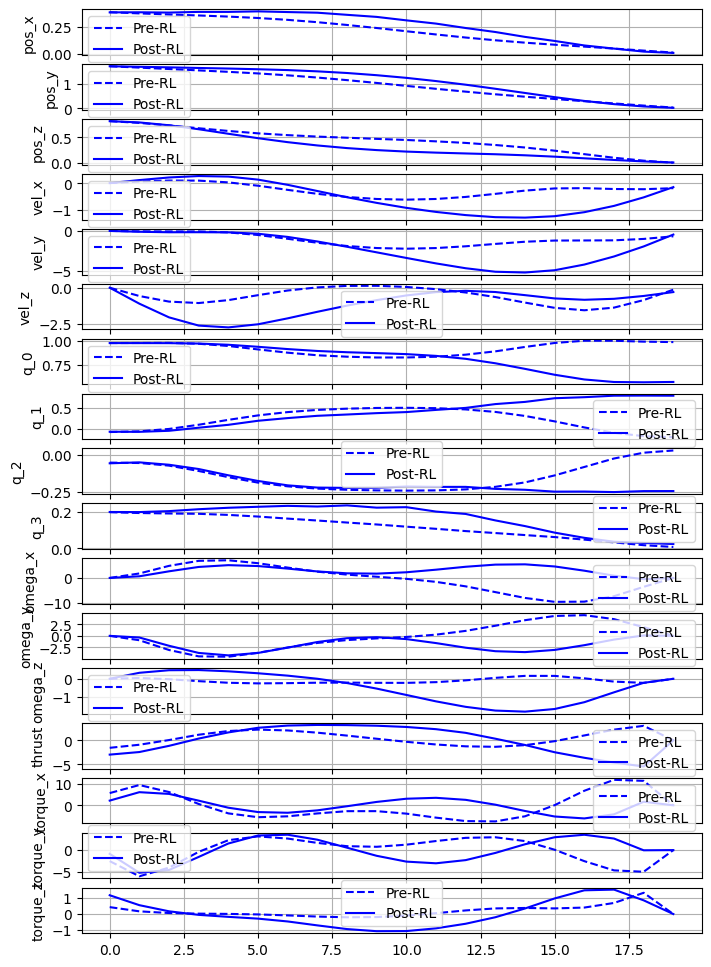

In [10]:
# plot rollouts with learned weights (post-RL)
solution = solver.solve(
    solver.initial_guess(problem_params), problem_params, weights
)

# plot rollouts with base weights (pre-RL)
fig, axes = plt.subplots(
    nrows=dynamics.num_states + dynamics.num_controls, figsize=(8, 12)
)
for i, ax in enumerate(axes.flatten()):
    if i < dynamics.num_states:
        ax.plot(solution_baseline.states[:, i], "b--", label="Pre-RL")
        ax.set_ylabel(dynamics.names_states[i])
    else:
        ax.plot(solution_baseline.controls[:, i-dynamics.num_states], "b--", label="Pre-RL")
        ax.set_ylabel(dynamics.names_controls[i-dynamics.num_states])
    ax.grid(True)
# plot solution after RL
for i, ax in enumerate(axes.flatten()):
    if i < dynamics.num_states:
        ax.plot(solution.states[:, i], "b", label="Post-RL")
    else:
        ax.plot(solution.controls[:, i-dynamics.num_states], "b", label="Post-RL")
    ax.legend()

plt.show()